In [1]:
from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

import wikipedia
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

%matplotlib inline

Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WorkPC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WorkPC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WorkPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#retrieve the page contents via the content attribute
artificial_intelligence = wikipedia.page("Artificial Intelligence").content
machine_learning = wikipedia.page("Machine Learning").content
deep_learning = wikipedia.page("Deep Learning").content
neural_network = wikipedia.page("Neural Network").content

#The sent_tokenize method returns list of sentences
artificial_intelligence = sent_tokenize(artificial_intelligence)
machine_learning = sent_tokenize(machine_learning)
deep_learning = sent_tokenize(deep_learning)
neural_network = sent_tokenize(neural_network)

#sentences from the four articles are joined together
artificial_intelligence.extend(machine_learning)
artificial_intelligence.extend(deep_learning)
artificial_intelligence.extend(neural_network)

In [3]:
artificial_intelligence

['In computer science, artificial intelligence (AI), sometimes called machine intelligence, is intelligence demonstrated by machines, unlike the natural intelligence displayed by humans and animals.',
 'Leading AI textbooks define the field as the study of "intelligent agents": any device that perceives its environment and takes actions that maximize its chance of successfully achieving its goals.',
 'Colloquially, the term "artificial intelligence" is often used to describe machines (or computers) that mimic "cognitive" functions that humans associate with the human mind, such as "learning" and "problem solving".As machines become increasingly capable, tasks considered to require "intelligence" are often removed from the definition of AI, a phenomenon known as the AI effect.',
 'A quip in Tesler\'s Theorem says "AI is whatever hasn\'t been done yet."',
 'For instance, optical character recognition is frequently excluded from things considered to be AI, having become a routine technolo

Data Preprocessing

In [4]:
#removing punctuations and numbers
#converting words into lowercase
#lemmatizing words to their root form
#stop words and the words with the length less than 4 will be removed from the corpus

import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [5]:
sent = preprocess_text("Artificial intelligence, is the most advanced technology of the present era")
print(sent)

artificial intelligence advanced technology present


In [6]:
final_corpus = [preprocess_text(sentence) for sentence in artificial_intelligence if sentence.strip() !='']
final_corpus[0]

'computer science artificial intelligence sometimes called machine intelligence intelligence demonstrated machine unlike natural intelligence displayed human animal'

In [7]:
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]
word_tokenized_corpus[0]

['computer',
 'science',
 'artificial',
 'intelligence',
 'sometimes',
 'called',
 'machine',
 'intelligence',
 'intelligence',
 'demonstrated',
 'machine',
 'unlike',
 'natural',
 'intelligence',
 'displayed',
 'human',
 'animal']

Creating Word Representations

In [8]:
# hyperparamteres for fasttext model

#size of the embedding vector
embedding_size = 60 

#size of the number of words occurring before and after the word
#The word embeddings for the input word are learned using these 80 output words 40 words before and after the input word
window_size = 40 

#minimum frequency of a word in the corpus for which the word representations will be generated
min_word = 5

#the most frequently occurring word will be down-sampled by this number
down_sampling = 1e-2

In [9]:
ft_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,                       # 1 for skipgram, 0 for BOW
                      iter=100)

In [10]:
print(ft_model.wv['artificial'])

[-0.32918197 -0.08339228 -0.35279003 -0.21770056 -0.5202688   0.20881768
 -0.14334698  0.6178058  -0.30827424  0.12988877  0.14421752  0.03897386
  0.38625306  0.30452228 -0.24923798 -0.05072284 -0.00797906 -0.22939192
 -0.24086693 -0.18792932  0.4196929  -0.50960153  0.20835197 -0.45293397
  0.46839964 -0.17895712 -0.1826723  -0.5197057   0.10577075 -0.17382471
  0.10334013  0.15342355 -0.22433798 -0.13988245 -0.14243767  0.14236858
 -0.10206473 -0.45264775  0.06732483  0.10949171  0.27611238  0.06973602
  0.05967955 -0.18646598  0.08611993 -0.404936    0.43412393  0.08587728
  0.09595913  0.16076224 -0.1701925  -0.14672829 -0.10648282  0.06446636
  0.3542009  -0.0259625   0.11342938 -0.5188407  -0.16633084 -0.15189563]


In [11]:
# finding most similar 5 words for some words
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['artificial', 'intelligence', 'machine', 'network', 'recurrent', 'deep']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

artificial:['intelligence', 'simulate', 'moral', 'neural', 'hopfield']
intelligence:['artificial', 'machine', 'human', 'philosophy', 'question']
machine:['ethic', 'learning', 'ethical', 'intelligence', 'concerned']
network:['neural', 'recurrent', 'biological', 'layer', 'perceptrons']
recurrent:['short', 'convolutional', 'hopfield', 'neural', 'network']
deep:['learning', 'speech', 'generative', 'neural', 'recurrent']


In [12]:
# cosine similarity btw words
print(ft_model.wv.similarity(w1='artificial', w2='intelligence'))

0.8445713


Visualizing Word Similarities

In [13]:
from sklearn.decomposition import PCA

all_similar_words = sum([v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)

['intelligence', 'simulate', 'moral', 'neural', 'hopfield', 'artificial', 'machine', 'human', 'philosophy', 'question', 'ethic', 'learning', 'ethical', 'intelligence', 'concerned', 'neural', 'recurrent', 'biological', 'layer', 'perceptrons', 'short', 'convolutional', 'hopfield', 'neural', 'network', 'learning', 'speech', 'generative', 'neural', 'recurrent']


In [14]:
print(len(all_similar_words))

30


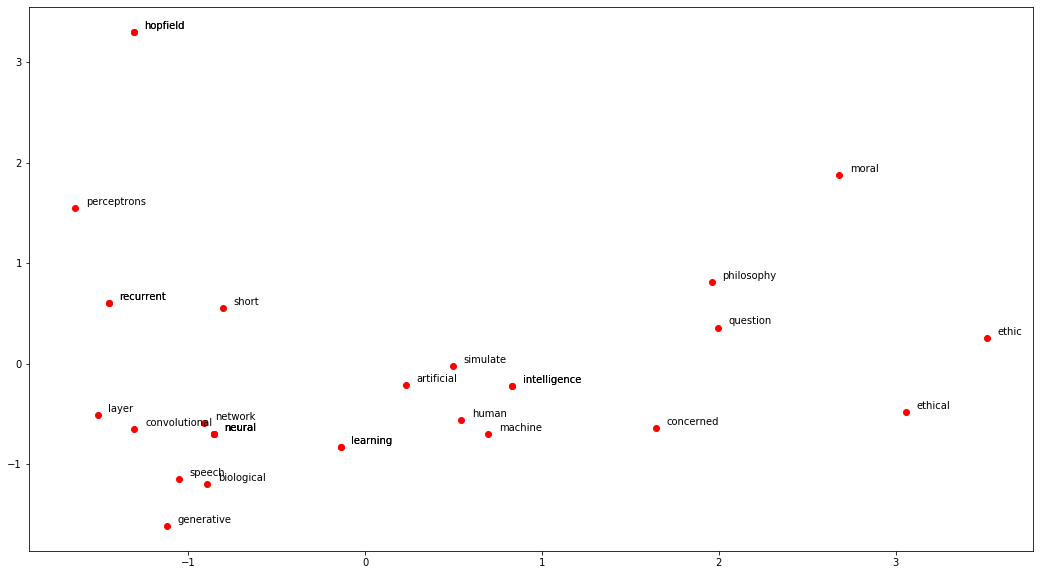

In [15]:
word_vectors = ft_model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')